# Q1: Online Retail_Anomaly Detecion

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:/Users/LIMI/Desktop/OnlineRetail.csv",encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
print(df.describe())

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


# Anomaly Detection

Here, We're still going with France.

Let's see the distribution of those parameters, and decided which methods we gonna use.

In [4]:
# We are going to see the Total money.  
# Filter the data for France
df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]
france_df = df[df["Country"] == "France"]

In [5]:
print(france_df.describe())

          Quantity    UnitPrice    CustomerID  TotalAmount
count  8557.000000  8557.000000   8491.000000  8557.000000
mean     12.911067     5.028864  12677.995996    23.069288
std      21.425031    79.909126    276.742088   117.181844
min    -250.000000     0.000000  12413.000000 -8322.120000
25%       5.000000     1.250000  12571.000000    10.500000
50%      10.000000     1.790000  12674.000000    16.500000
75%      12.000000     3.750000  12689.000000    23.400000
max     912.000000  4161.060000  14277.000000  4161.060000


### Quantity: 

Extremely negative values (minimum -250) may indicate large number of refund records.

Extremely positive values (maximum 912) may indicate explosive items . 

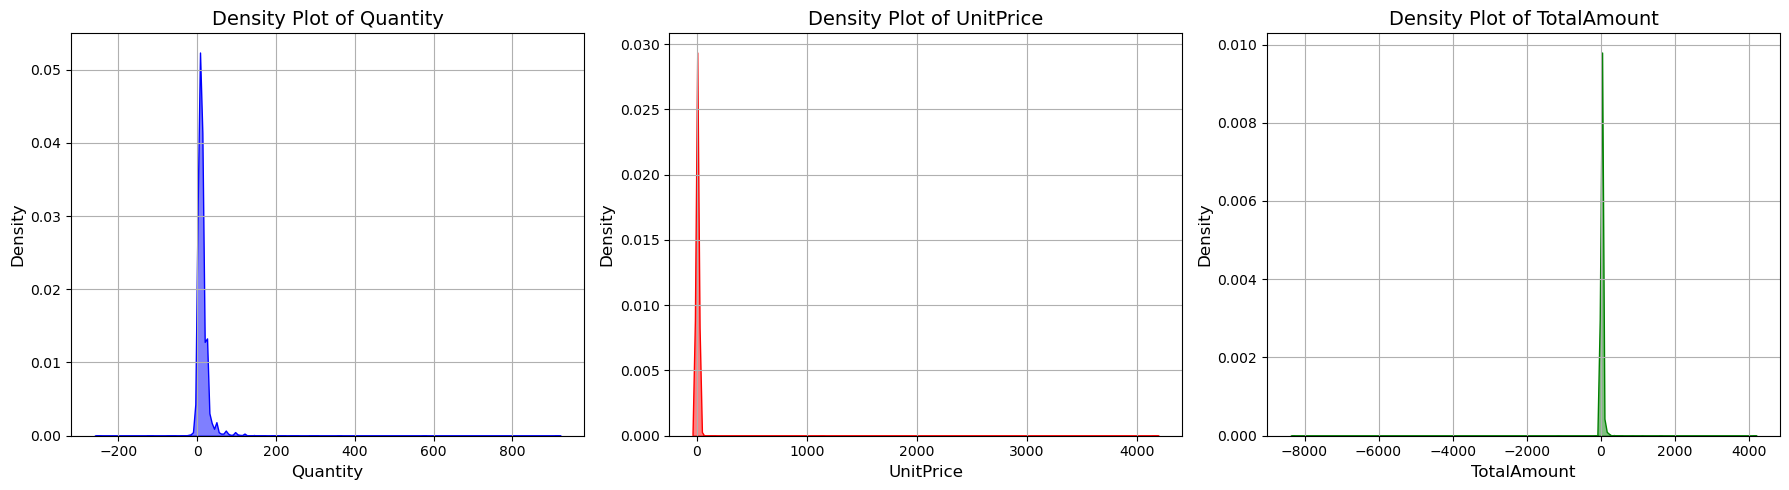

In [6]:
#Create sub plot 
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

# Quantity plot
sns.kdeplot(france_df['Quantity'], fill=True, color='blue', alpha=0.5, ax=axes[0])
axes[0].set_title("Density Plot of Quantity", fontsize=14)
axes[0].set_xlabel("Quantity", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].grid(True)

# UnitPrice plot
sns.kdeplot(france_df['UnitPrice'], fill=True, color='red', alpha=0.5, ax=axes[1])
axes[1].set_title("Density Plot of UnitPrice", fontsize=14)
axes[1].set_xlabel("UnitPrice", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].grid(True)

# TotalAmount plot
sns.kdeplot(france_df['TotalAmount'], fill=True, color='green', alpha=0.5, ax=axes[2])
axes[2].set_title("Density Plot of TotalAmount", fontsize=14)
axes[2].set_xlabel("TotalAmount", fontsize=12)
axes[2].set_ylabel("Density", fontsize=12)
axes[2].grid(True)

# layout the plot
plt.tight_layout()
plt.show()

### From the graph we can see: 

1. Quantity: 
This distribution is highly skewed (skewness) and clearly does not conform to a normal distribution.

2. UnitPrice: 
The data is concentrated in a smaller domain of values, with a small number of larger values lengthening the tails of the distribution. Moreover, High concentration of data in areas close to 0

3. TotalAmount: 
Because Totalamount = Quantity * UnitPrice, so it's more affected by the extreme values. 

### So we are going to choose IQR, because: 

1. IQR is usually applied to continuous variables

2. IQR is sensitive to outliers in the data, but is not as susceptible to the extremes of outliers as the mean and standard deviation. This makes it particularly suitable for asymmetric distributions with outliers.

3. IQR does not depend on whether the data conforms to a normal distribution, and is suitable for dealing with asymmetric, skewed, or multi-peaked distributions.

In [7]:
# Recalculate IQR for Quantity, UnitPrice, and TotalAmount for France
Q1_quantity_fr = france_df["Quantity"].quantile(0.25)
Q3_quantity_fr = france_df["Quantity"].quantile(0.75)
IQR_quantity_fr = Q3_quantity_fr - Q1_quantity_fr

Q1_price_fr = france_df["UnitPrice"].quantile(0.25)
Q3_price_fr = france_df["UnitPrice"].quantile(0.75)
IQR_price_fr = Q3_price_fr - Q1_price_fr

Q1_amount_fr = france_df["TotalAmount"].quantile(0.25)
Q3_amount_fr = france_df["TotalAmount"].quantile(0.75)
IQR_amount_fr = Q3_amount_fr - Q1_amount_fr


In [8]:
# Define stricter bounds for anomalies
lower_bound_quantity_fr = Q1_quantity_fr - 3 * IQR_quantity_fr
upper_bound_quantity_fr = Q3_quantity_fr + 3 * IQR_quantity_fr

lower_bound_price_fr = Q1_price_fr - 3 * IQR_price_fr
upper_bound_price_fr = Q3_price_fr + 3 * IQR_price_fr

lower_bound_amount_fr = Q1_amount_fr - 3 * IQR_amount_fr
upper_bound_amount_fr = Q3_amount_fr + 3 * IQR_amount_fr


In [9]:
# Mark Quantity anomalies for France
france_df["Quantity_Anomaly"] = france_df["Quantity"].apply(
    lambda x: 1 if x < lower_bound_quantity_fr or x > upper_bound_quantity_fr else 0
)

# Mark UnitPrice anomalies for France
france_df["UnitPrice_Anomaly"] = france_df["UnitPrice"].apply(
    lambda x: 1 if x < lower_bound_price_fr or x > upper_bound_price_fr else 0
)

# Mark TotalAmount anomalies for France
france_df["TotalAmount_Anomaly"] = france_df["TotalAmount"].apply(
    lambda x: 1 if x < lower_bound_amount_fr or x > upper_bound_amount_fr else 0
)


C:\Users\LIMI\AppData\Local\Temp\ipykernel_21784\2831527807.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france_df["Quantity_Anomaly"] = france_df["Quantity"].apply(
C:\Users\LIMI\AppData\Local\Temp\ipykernel_21784\2831527807.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france_df["UnitPrice_Anomaly"] = france_df["UnitPrice"].apply(
C:\Users\LIMI\AppData\Local\Temp\ipykernel_21784\2831527807.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [10]:
# Summarize anomaly flags for France
france_anomaly_summary = france_df[
    ["Quantity_Anomaly", "UnitPrice_Anomaly", "TotalAmount_Anomaly"]
].sum()

print(france_anomaly_summary)


Quantity_Anomaly       476
UnitPrice_Anomaly      486
TotalAmount_Anomaly    460
dtype: int64


Here we have screened for outliers, and they are all close in number, next we look to see if they occur at the same time

In [11]:
Quantity_Anomalies =  france_df[france_df["Quantity_Anomaly"] == 1]
UnitPrice_Anomalies =  france_df[france_df["UnitPrice_Anomaly"] == 1]
TotalAmount_Anomalies =  france_df[france_df["TotalAmount_Anomaly"] == 1]

print(TotalAmount_Anomalies)

       InvoiceNo StockCode                          Description  Quantity  \
26        536370     22728            ALARM CLOCK BAKELIKE PINK        24   
27        536370     22727            ALARM CLOCK BAKELIKE RED         24   
34        536370     22326  ROUND SNACK BOXES SET OF4 WOODLAND         24   
40        536370     22900      SET 2 TEA TOWELS I LOVE LONDON         24   
7894      537065     22968           ROSE COTTAGE KEEPSAKE BOX          8   
...          ...       ...                                  ...       ...   
532710    580986      POST                              POSTAGE         4   
532921    581001     23480       MINI LIGHTS WOODLAND MUSHROOMS        32   
532935    581001     22728            ALARM CLOCK BAKELIKE PINK        18   
532936    581001     22726           ALARM CLOCK BAKELIKE GREEN        24   
537461    581279     22423             REGENCY CAKESTAND 3 TIER         6   

            InvoiceDate  UnitPrice  CustomerID Country  TotalAmount  \
26  

In [12]:
# Filtering for simultaneous = 1 for Quantity_Anomaly and UnitPrice_Anomaly


print(f"Rows where Quantity_Anomaly：{france_df[france_df['Quantity_Anomaly'] == 1].shape[0]}")
print(f"Rows where UnitPrice_Anomaly：{france_df[france_df['UnitPrice_Anomaly'] == 1].shape[0]}")

intersection = france_df[
    (france_df["Quantity_Anomaly"] == 1) & 
    (france_df["UnitPrice_Anomaly"] == 1)
]
print(f"Rows where both anomalies：{intersection.shape[0]}")

Rows where Quantity_Anomaly：476
Rows where UnitPrice_Anomaly：486
Rows where both anomalies：0


Unfortunately we didn't find any times when both Quantities and UnitPrice were detected as outliers. So next we will discuss them separately. Next, we gonna use box plot to see the anomalies' distribution. 

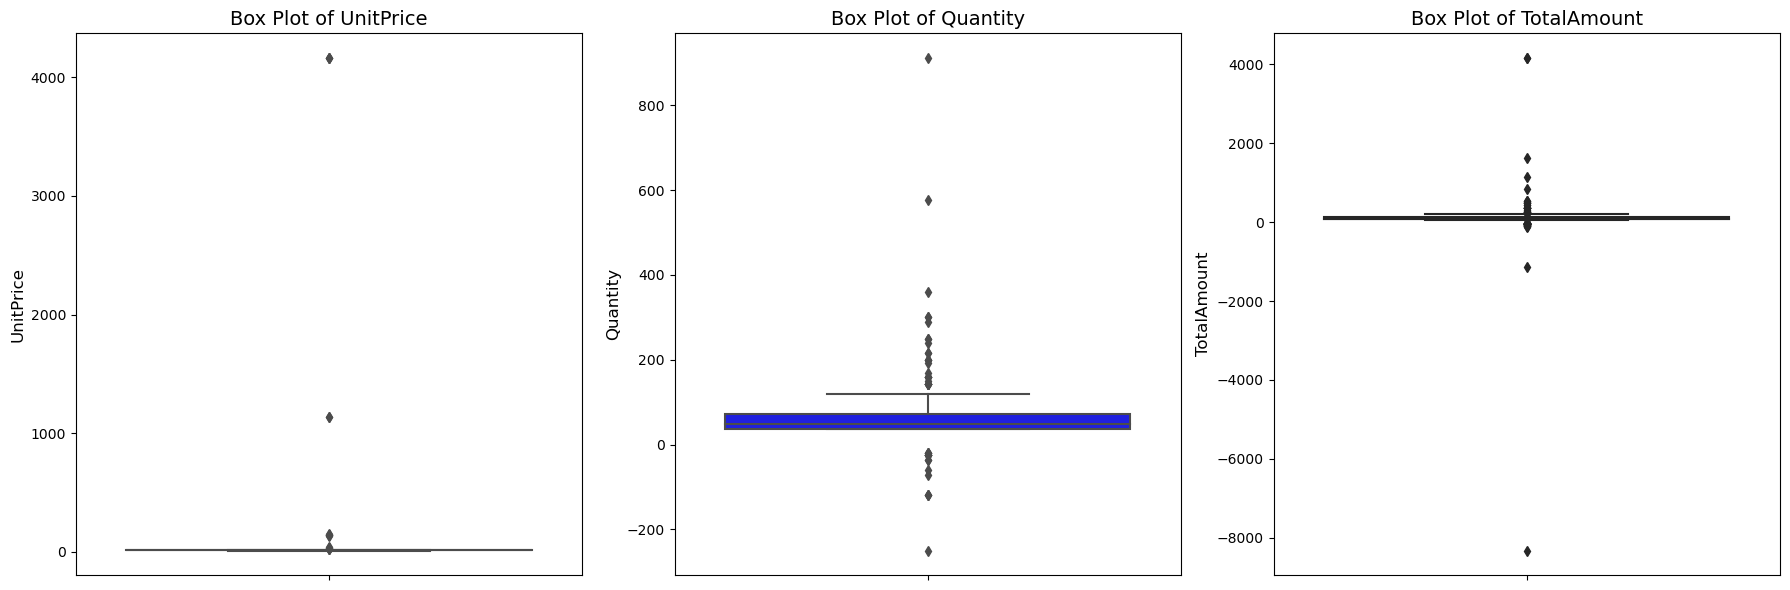

In [13]:
# see the Anomalies. 

fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 

# Quantity 
sns.boxplot(y=Quantity_Anomalies["Quantity"], ax=axes[1], color='blue')
axes[1].set_title("Box Plot of Quantity", fontsize=14)
axes[1].set_ylabel("Quantity", fontsize=12)
axes[1].set_xlabel("")

# UnitPrice 
sns.boxplot(y=UnitPrice_Anomalies["UnitPrice"], ax=axes[0], color='red')
axes[0].set_title("Box Plot of UnitPrice", fontsize=14)
axes[0].set_ylabel("UnitPrice", fontsize=12)
axes[0].set_xlabel("")


# TotalAmount 
sns.boxplot(y=TotalAmount_Anomalies["TotalAmount"], ax=axes[2], color='green')
axes[2].set_title("Box Plot of TotalAmount", fontsize=14)
axes[2].set_ylabel("TotalAmount", fontsize=12)
axes[2].set_xlabel("")


plt.tight_layout()
plt.show()

In [27]:
# check the high price information
UnitPrice_high = UnitPrice_Anomalies[UnitPrice_Anomalies["UnitPrice"] > 4000]
print(UnitPrice_high)

       InvoiceNo StockCode Description  Quantity       InvoiceDate  UnitPrice  \
422351    573077         M      Manual         1  10/27/2011 14:13    4161.06   
422375   C573079         M      Manual        -2  10/27/2011 14:15    4161.06   
422376    573080         M      Manual         1  10/27/2011 14:20    4161.06   

        CustomerID Country  TotalAmount  Quantity_Anomaly  UnitPrice_Anomaly  \
422351     12536.0  France      4161.06                 0                  1   
422375     12536.0  France     -8322.12                 0                  1   
422376     12536.0  France      4161.06                 0                  1   

        TotalAmount_Anomaly  
422351                    1  
422375                    1  
422376                    1  


We should pay more attention on UnitPrice which equals to 0. Perhaps items may be given away as complimentary gifts (e.g. buy one get one free, trial packs, etc.) An interesting thing is one customer purchased these very high price item twice, but this customer also returned these two items. We suggest that the manager should pay more attention on this and do the customer survey on time to figure out the reason. 

In terms of Quantity, the huge postive values might mean that those are very popular items or explosive item. The mall can prepare some more, Anomaly detection can also help malls determine what the best-selling products are. Quantity < 0 might means the items are returned back or the orders cancelled. So in this part, malls can check after-sales service based on this part of the order. 

In terms of TotalAmount, Shopping malls can adjust their sales strategies based on these filtered 'anomalies'. 

Next, we can see the whole information in Quantity_Anomalies, UnitPrice_Anomalies and TotalAmount_Anomalies. 

In [14]:
Quantity_Anomalies

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Quantity_Anomaly,UnitPrice_Anomaly,TotalAmount_Anomaly
31,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/2010 8:45,0.85,12583.0,France,40.80,1,0,0
44,536370,22492,MINI PAINT SET VINTAGE,36,12/1/2010 8:45,0.65,12583.0,France,23.40,1,0,0
7943,537065,21829,DINOSAUR KEYRINGS ASSORTED,36,12/5/2010 11:57,0.21,12567.0,France,7.56,1,0,0
14156,537463,22467,GUMBALL COAT RACK,36,12/7/2010 10:08,2.10,12681.0,France,75.60,1,0,1
14160,537463,22348,TEA BAG PLATE RED RETROSPOT,36,12/7/2010 10:08,0.85,12681.0,France,30.60,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
527342,580705,22437,SET OF 9 BLACK SKULL BALLOONS,40,12/5/2011 16:28,0.85,12683.0,France,34.00,1,0,0
529621,580736,22610,PENS ASSORTED FUNNY FACE,36,12/6/2011 8:55,0.19,12716.0,France,6.84,1,0,0
532919,581001,22540,MINI JIGSAW CIRCUS PARADE,48,12/7/2011 8:07,0.19,12583.0,France,9.12,1,0,0
532920,581001,22544,MINI JIGSAW SPACEBOY,48,12/7/2011 8:07,0.19,12583.0,France,9.12,1,0,0
